## Dynamics of the COVID-19 infection

### 0. Setup and imports

In [2]:
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt
from copy import deepcopy

### 1. Models for the simulation of the COVID-19 Pandemic

As the current Sars-CoV-2 Pandemic unfolds, research groups around the world are trying to model the dynamics of the ongoing Pandemic. Epediemiological models are needed to forecast the infections, guide policy makers and probe interventions measures. Even though multiple approaches have been implemented to elucidate different facets of the Pandemic, most models are based on the same SEIR [2] framework. The population of interest is seperated into different compartements, based on theil contact with the pathogen. Susceptible (S) People can become exposed (E), which can lead to an succsesfull infection with the virus. Infected (I) Population can then further infect susceptible indivisuals until recovery (R). As described the SEIR model assumes immunity after overcomming the infection.

$
\newcommand{ptr}[1]{\overset{\mathtt{#1}}{\longrightarrow}}                                  
                                             \fbox{S(t)}  \ptr{exposition}
                                              \fbox{E(t)}    \ptr{infection}
                                              \fbox{I(t)}     \ptr{recovery}
                                             \fbox{R(t)}
$
<br><br>
We implemented two different model, which are both extending this concept.

##### The Neher Model - COVID-19 Dynamics
The research group from the Swiss Institute of Bioinformatics, led by Richard Neher, developed a model to simulate the current Sars-CoV-2 Pandemic [1]. The Model is based on the described SEIR  framework, which was extended to account for the specific questions of interest in the current Pandemic. A special focus was set to asses the strain on the healthcare system and to model the capacity overflow on ICU units. Furthermore, the effect on different age groups can be assessed and the isolation of age groups can be modeled with high fidelity. and the effect of seasonal forcing on the spread of infection can be simulated [3]. The model was published as an interactive web application which freely accessible and lets the user explore fitted parameters based on observational data and custom parameters [4]. 

##### The Colizza Model
Another group of researchers arround Laura Di Domenico from the INSERM [5] also created a model to describe the Sars-CoV-2 Pandemic. The base for the model is also a modified SEIR framework. It is extended to bring in the contacts between people and the different behaviours of infected perople into calculation.  
At the moment, europe and the world are currently under strict social distancing measures. It is not clear, how the different countries can reduce the strict counter measures against the virus, without running into a second wave.  
Therefor the paper addresses the question, what influence have the applied counter measures on the development of the pandemi and what are possible exit strategies to get out of the lockdown in a save way.  
The paper is published as a pre-print and publicly available [6]. It contains information about the model and the used parameter but does not publish the sources.

### 2. The Neher model, modeling the health system strain and ICU Overflow

The default SEIR model was extendend to assess the strain of the pandemic on the healthcare system. Therefore the clinical stages between infection and recovery or Death (D) were modeled explicitly. Infected patients can transition to be hospitalized (H) based on the severity of the disease and treatement in an intensive care unit can become necessary. Based on the number of free ICU beds, these patients will be transitioned to the group of critical (C) patients in ICU or can become part of an overflow (O) compartement with a lower probability of recovery. This allows to model the case of an ICU overflow, which is associated with a higher fatality rate. Forecasting this is highly relevant, as an ICU overflow and overwhelming strain on the healthcare system needs to be mitigated in order to combat the Pandemic [5]. 

All specified compartments are modeled on the level of individual age groups. Each of the age-groups as denoted by the index $a$ can have its own degree of isolation and probabilities to develope a critical stage of the disease. This is crucial in order to account for the varying severity of the disease based on the age [6]. Age specific compartements are implemented as age groups of ten Years $a=\{(0{\text -}9), (10{\text -}19), (20{\text -}29), (30{\text -}39), (40{\text -}49), (50{\text -}59), (60{\text -}69), (70{\text -}79), (80+)\}$.

$S_a(t)$ Susceptible people<br>
$E_{1a}(t), E_{2a}(t), E_{3a}(t)$ Incubation states between infection and infectiousnes<br>
$I_a(t)$ Infected individuals<br>
$R_a(t)$ Recovered patients<br>
$D_a(t)$ Fatalaties due to infection<br>

$H_a(t)$ Hospitalized patients<br>
$C_a(t)$ Critical patients in ICU<br>
$O_a(t)$ Critical patients which can't go to ICU because of ICU overflow<br>

$$
\begin{align*}
    \frac{dS_a(t)}{dt} &= -\beta S_a(t) N^{-1} \sum_{b} I_b(t) \\
    \frac{dE_{1a}(t)}{dt} &= \beta S_a(t) N^{-1} \sum_{b} I_b(t) - 3 E_{1a}(t) t_l^{-1}\\
    \frac{dE_{2a}(t)}{dt} &= 3 E_{1a}(t) t_l^{-1} - 3 E_{2a}(t) t_l^{-1}\\
    \frac{dE_{3a}(t)}{dt} &= 3 E_{2a}(t) t_l^{-1} - 3 E_{3a}(t) t_l^{-1}\\
    \frac{dI_a(t)}{dt} &= 3 E_3(t) t_l^{-1} - I_a(t) t_i^{-1} \\
    \frac{dH_a(t)}{dt} &= (1-m_a) I_a(t)t_i^{-1}  + (1-f_a) C_a(t)t_c^{-1} - H_a(t)t_h^{-1}\\
    \frac{dC_a(t)}{dt} &= c_a H_a(t)t_h^{-1} - C_a(t)t_c^{-1}\\
    \frac{dR_a(t)}{dt} &= m_a I_a(t) t_i^{-1} + (1-c_a)H_a(t)t_h^{-1} \\
    \frac{dD_a(t)}{dt} &= f_a C_a(t)t_c^{-1}
\end{align*}
$$

### 2.2. Parameters of the model
The model is specified by a number of age specific and general paramters.<br>
Parameters for the transition times are age independend but could be extended to become age specific.<br>

$t_l$ Latency time between infection and infectiousness<br>
$t_i$ Average time between onset of sickness and recovery<br>
$t_h$ Average time of a hospital stay after admission<br>
$t_c$ Average time of ICU stay if the infection progresses with higher severity<br><br>

Parameters for the progression of the disease and isolation are age dependent<br>

$m_a$ The fraction of cases, which are asymptotic or mild<br>
$c_a$ The fraction of severe cases that turn critical<br>
$f_a$ The fraction of critical cases that end fatal<br>
$\zeta_{a}$ Degree of isolation of the specified group<br><br>


The rate of transmission $\beta_a(t)$ of the infection is an age and time dependent parameter. It describes the seasonal infection rate taking into account the seasonal forcing, isolation of the age group and interventions. An infectious Person transmits the virus to $\beta_a(t)t_i$ healthy persons on average over the course of the infection.<br>

$\beta_a(t) = R_0 \zeta_{a}(1+\epsilon \cos(2\pi(t-t_{max})/365))t_i^{-1}  \prod_{k}M_{k}(t)  $

$R_0$ Average number of transmissions during the course of infection<br><br>
$t_{max} $Time of maximum infectivity over the course of the year due to seasonal forcing<br>
$\epsilon$ Degree of seasonal forcing<br>
$M_{k}(t)$ Time dependend inteventions specifying the degree of reduction in infectivity<br><br>

$N$ Population size<br>

### 2.3. Implementation of the model

In [121]:
class Model:

    def __init__(self, population, agePar, par, cm):
        self.N = np.sum(population)
        self.population = population
        self.agePar = agePar
        self.par = par
        self.cm = cm
        
    def beta(self, t, R_0, zeta, cm):
        epsilon = self.par["seasonalForcing"]
        t_max = self.par["t_max"]
        t_i = self.par["t_i"]
        
        R = R_0 * (1-zeta) * (1+epsilon*np.cos(2*np.pi*(t-t_max)/365))
        
        if isinstance(t,np.ndarray):
            for m in cm:
                effect = np.where(np.logical_and(m[0] < t, m[1] > t))
                R[effect] *= (1 - m[2])
        
        else:
            for m in cm:
                R *= (1 - m[2]) if m[0] < t < m[1] else 1
                
        return R/t_i
    
    def plotR0(self):
        
        t = np.linspace(1,365,365)
        
        cm = []
        for m in self.cm:
            cm.append([m["time"][0],m["time"][1], m["reduction"][1]])
                
        R_0_l = self.beta(t,self.par["R0"][0],0, cm)*self.par["t_i"]
                       
                       
        cm = []
        for m in self.cm:
            cm.append([m["time"][0],m["time"][1], m["reduction"][0]])
                       
        R_0_u = self.beta(t,self.par["R0"][1],0, cm)*self.par["t_i"]
        
        plt.fill_between(t,R_0_l, R_0_u, alpha = 0.5)
        plt.ylim((0,max(R_0_u)+1))
        plt.plot([0,364],[1,1], "--", c="red")
        fig = plt.gcf()
        fig.set_size_inches(10, 4)
        plt.xticks([0, 28, 59, 89, 120, 150, 181, 211, 242, 272, 303, 333,364], 
                   ["January", 'February', "March", "April", "May", "June", "July", "August", "September", "October", "November", "December"], rotation=45)
        plt.show()
        
    def system(self,v,t,R0,cm):
        o = np.array([])
        v = np.reshape(v,(9,9))
        sumI = np.sum(v[:,4])
            
        t_l = self.par["t_l"]
        t_i = self.par["t_i"]
        t_h = self.par["t_h"]
        t_c = self.par["t_c"]
        for i, age in enumerate(v):
            ageP = self.agePar[i]
            
            m_a = 1-ageP[1]
            c_a = 1-ageP[2]
            f_a = 1-ageP[3]
            
            b = self.beta(t,R0,0, cm)
            
            S, E1, E2, E3, I, H, C, R, D = age.tolist()
            
            dSdt = -b*S*sumI/self.N
            dE1dt = b*S*sumI/self.N - 3*E1/t_l
            dE2dt = 3*E1/t_l - 3*E2/t_l
            dE3dt = 3*E2/t_l - 3*E3/t_l
            dIdt = 3*E3/t_l - I/t_i
            dHdt = (1-m_a)*I/t_i + (1-f_a)*C/t_c - H/t_h
            dCdt = c_a*H/t_h - C/t_c
            dRdt = m_a*I/t_i + (1-c_a)*H/t_h
            dDdt = f_a*C/t_c

            o = np.concatenate((o,[dSdt,dE1dt,dE2dt,dE3dt,dIdt,dHdt,dCdt,dRdt,dDdt]))

        return o
    
    def setTime(self, time):
        self.time = time
    
    def simulate(self):
        p = np.expand_dims(self.population, axis=0).T
        v = np.zeros((9,8))   
        v0 = np.concatenate((p,v),axis=1)
        
        v0[:,4] = 1
        
        v0 = np.reshape(v0,(81))
        steps = (self.time[1]-self.time[0])*5
        t = np.linspace(self.time[0],self.time[1],steps)
        
        
        self.solutionSum = []
        self.solution = []
        
        samples = 2
        
        for i in range(samples):
            R0 = np.random.uniform(low=self.par["R0"][1],high=self.par["R0"][1])
            print(R0)
            cm = []
            for m in self.cm:
                cm.append([m["time"][0],m["time"][1], np.random.uniform(low=m["reduction"][0],high=m["reduction"][1])])
            print(cm)
   
        
            sol = odeint(self.system, v0, t, args=(R0,cm,))
            solArr = np.reshape(sol,(steps,9,9))
            self.solution.append(solArr)
            self.solutionSum.append(np.sum(solArr,axis=1))
            
    def calcConfidence(self):
        
        steps = (self.time[1]-self.time[0])*5
        for time in range(steps):
            for age in range(len(self.solution[0][time])):
                for compartement in range(len(self.solution[0][time][age])):
                    print(self.solution[0][time][age][compartement])
                    
            break
        
    
        
    def plot(self):
        solution = self.solutionSum[0]
        
        steps = (self.time[1]-self.time[0])*5
        t = np.linspace(self.time[0],self.time[1],steps)
        
        larger = np.where(solution < 1)
        solution[larger] = 0
        
        plt.fill_between(t, self.solutionSum[0][:,0],self.solutionSum[1][:,0], color="lightblue", alpha = 0.3, label=r"Susceptible")
        plt.fill_between(t, self.solutionSum[0][:,4],self.solutionSum[1][:,4], color="orange", alpha = 0.3, label=r"Infected")
        plt.fill_between(t, self.solutionSum[0][:,5],self.solutionSum[1][:,5], color="indianred", alpha = 0.3, label=r"Hospitalized")
        plt.fill_between(t, self.solutionSum[0][:,6],self.solutionSum[1][:,6], color="red", alpha = 0.3, label=r"ICU")
        plt.fill_between(t, self.solutionSum[0][:,7],self.solutionSum[1][:,7], color="green", alpha = 0.3, label=r"Recovered")
        plt.fill_between(t, self.solutionSum[0][:,8],self.solutionSum[1][:,8], color="dimgrey", alpha = 0.3, label=r"Dead")
        """
        plt.plot(t,solution[:,0], label=r"Susceptible")
        plt.plot(t,solution[:,4], label=r"Infected", c="orange")
        plt.plot(t,solution[:,5], label=r"Hospitalized", c="indianred")
        plt.plot(t,solution[:,6], label=r"ICU", c="red")
        plt.plot(t,solution[:,7], label=r"Recovered", c="green")
        plt.plot(t,solution[:,8], label=r"Dead", c="dimgrey")
        """
        plt.title("cumulative groups")
        plt.xlabel("t in days")
        plt.legend(loc='best')
        fig = plt.gcf()
        plt.yscale("log")
        plt.ylim(bottom=1)
        fig.set_size_inches(14, 10)
        plt.xticks([28, 59, 89, 120, 150, 181, 211, 242, ], 
                   ['February', "March", "April", "May", "June", "July", "August"], rotation=45)
        plt.show()
        
    def plotAgeGroups(self):
        ageGroups = np.arange(0,9)
        
        solution = np.array(self.solution[0])
        maxc = np.amax(solution,axis=0)
        lastStep = np.array(solution[-1])
        
        ax = plt.gca()
        infected = maxc[:,5]
        ax.bar(ageGroups-0.25, infected,color="indianred", alpha = 0.3, width=0.25, label=r"Hospitalized")
        
        infected = maxc[:,6]
        ax.bar(ageGroups, infected,color="red", alpha = 0.3, width=0.25, label=r"ICU")
        
        dead = maxc[:,-1]
        ax.bar(ageGroups+0.25, dead,color="dimgrey", alpha = 0.3, width=0.25, label=r"Dead")
        plt.legend(loc=2)
        
        ax2 = ax.twinx()
        
        affected = 100*(self.population-lastStep[:,0])/self.population
        
        ax2.bar(ageGroups-0.45, dead,color="dimgrey", width=0.1, label=r"% of group affected")
        
        ax2.legend(loc=0)
        fig = plt.gcf()
        fig.set_size_inches(14, 6)
        
        plt.xticks(ageGroups, 
                   ['0-9', "10-19", "20-29", "30-39", "40-49", "50-59", "60-69", "70-79", "80+"], rotation=45)
        print(dead)

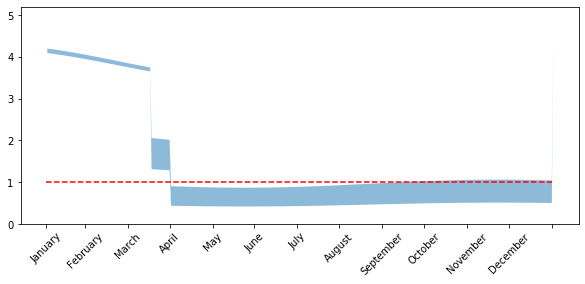

3.9
[[75, 365, 0.6310013347871991], [89, 365, 0.6132281397050027]]
3.9
[[75, 365, 0.48765419946912086], [89, 365, 0.5826017853580046]]


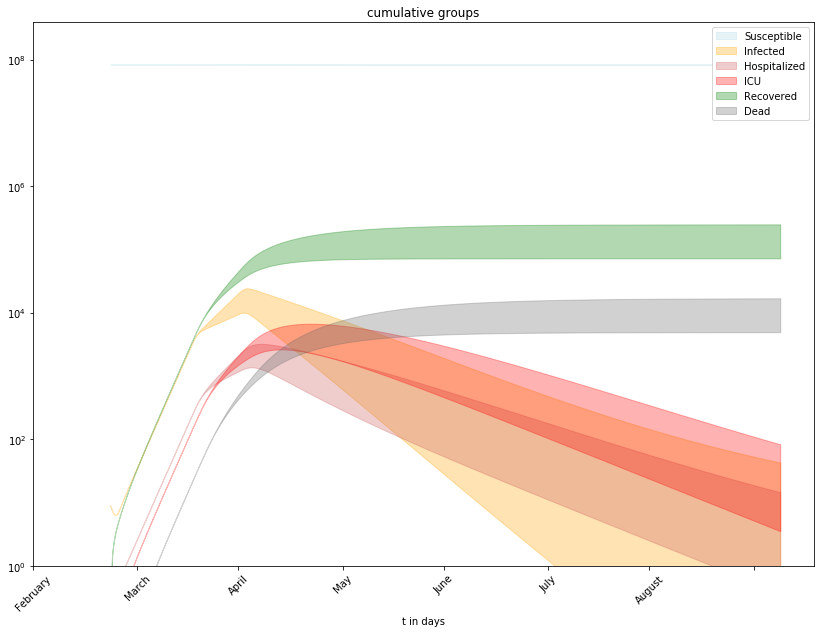

[  66.56036487  186.4747135   220.48764928  236.58797511  411.34597907
  787.25326762 1273.71261765  900.79808558  774.85242024]


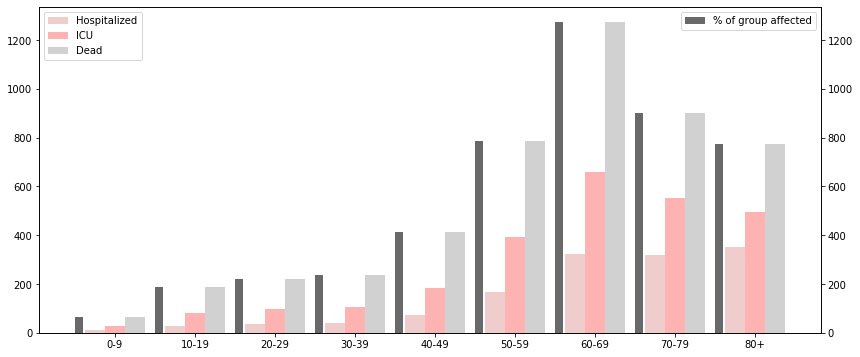

In [122]:
germanPopulation = np.array([
    7880902,
    7930616,
    9377359,
    10872019,
    10243351,
    13488393,
    10644140,
    7471414,
    5875748])

ageParameters = np.array([
    [0.05, 0.01, 0.05, 0.30, 0.0],
    [0.05, 0.03, 0.10, 0.30, 0.0],
    [0.10, 0.03, 0.10, 0.30, 0.0],
    [0.15, 0.03, 0.15, 0.30, 0.0],
    [0.20, 0.06, 0.20, 0.30, 0.0],
    [0.25, 0.10, 0.25, 0.40, 0.0],
    [0.30, 0.25, 0.35, 0.40, 0.0],
    [0.40, 0.35, 0.45, 0.50, 0.0],
    [0.50, 0.50, 0.55, 0.50, 0.0]
])

interventions = [
    {"time": [75,365],
         "reduction": [0.45,0.64]},
     {"time": [89,365],
         "reduction": [0.55,0.66]}]

parameters = {
   "seasonalForcing" : 0.10,
    "t_max": 325,
    "R0" : [3.8,3.9],
    "t_l": 3,
    "t_i": 3,
    "t_h": 3,
    "t_c": 14
}

model = Model(germanPopulation, ageParameters, parameters, interventions)
model.plotR0()
model.setTime([51,250])
model.simulate()
#model.calcConfidence()
model.plot()
model.plotAgeGroups()


### 3. The Colizza Model, simulating contact behaviour

The model expandet SEIR model and includes multiple states infection states ($I$).
The state is split into the prodromic phase ($I_p$), followed by four states, repersenting the severity of  Asymptomatic Infectious state ($I_{a}$), Paucysymptomatic Infectious($I_{ps}$), Symptomatic Infectious ($I_{ms}$) and the state for Symptomatic Infectious with severe symptoms ($I_{ss}$).  
The first three states show a mild course after infection. The different states are used to model the behaviour of affected people in more detail. With the parameters it is possible to represent the selfisolation because of the illness. It is assumed that, during a sever illness, people reduce their contacts by 75% [7].  
All people in state $I_{ss}$ have a stay in the hospital, either in the normal tracks or in the ICU.  
These last two states help to analyse, if a counter measure is enough to prevent the health care system from collapsing.  
The compartmental model was initialy build based on French hospital data APHP (Assistance publique - Hôpitaux de Paris[8]).
Afterwards it was rescaled to fit whole Île-de-France region.  
The paper separates the population into three groups, children (c), adults (a) and seniors(s). Each group interacts with the others, but has a different contact level.


The general model is shown in Figure 1:

Graph, Fig 1

It can be described as a system of first order ordinary differential equations:

$$
\begin{align*}
    \frac{dS}{dt} = -b * S *(I_{p} + I_{a} + I_{ps} + I_{ms} + I_{ss})\\
    \frac{dE}{dt}=b * S * (I_{p} + I_{a} + I_{ps} + I_{ms} + I_{ss}) -e * E\\
    \frac{dI_{p}}{dt}=e*E - u_{p} * I_{p}\\
    \frac{dI_{a}}{dt}=p_{a}*u_{p}*I_{p} - u * I_{a}\\
    \frac{dI_{ps}}{dt}=(1-p_{a}) * p_{ps} * u_{p} * I_{p} - u * I_{ps}\\
    \frac{dI_{ms}}{dt}=(1-p_{a})* p_{ms} * u_{p} * I_{p} - u * I_{ms}\\
    \frac{dI_{ss}}{dt}=(1-p_{a})* p_{ss} * u_{p} * I_{p} - u * I_{ss}\\
    \frac{dH}{dt}=(1 - p_{ICU}) * u * I_{ss} - (\lambda_{H,R} + \lambda_{H,D}) * H\\
    \frac{dI_{ICU}}{dt}=p_{ICU} * u * I_{ss} - (\lambda_{ICU,R} + \lambda_{ICU,D}) * ICU\\
    \frac{dR}{dt}=u * (I_{a} + I_{ps} + I_{ms}) + l_{H,R} * H + l_{ICU,R} * ICU \\
    \frac{dD}{dt}l_{H,D} * H + l_{ICU,D} * ICU
\end{align*}
$$

To get a better understanding of the ODE system the different  population groups were not included in this table. In the implementation all three classes are used.

#### 3.1 Creating the contact matrix

The main contact matrix influencing the model is based on multiple contact matrices. Each matrix represents a given situation of the daily life and has its own amount of contacts between the different groups.  
The researchers devided the daily life in six different parts, each with a different ratio. As a result, we have six matrices: $K_{household}$, $K_{school}$, $K_{workplace}$, $K_{transport}$, $K_{leisure}$ and $K_{other}$.


To get our input matrix $K$ for the model, we can use the weighted sum of all matrices:
$$K=\sum{K_{place}*ratio_{place}}$$

To show the importance of this contact matrices, we created one baseline matrix $K_{baseline}$ and one matrix to decribe the influence of the counter measures $K_{measure}$.

The contact matrix is organized that $K_{00}$ represents the contacts from children to children, $K_{01}$ from adults to children and so on.
$$K=
\begin{pmatrix}
    c\rightarrow c && a\rightarrow c && s\rightarrow c\\
    c\rightarrow a && a\rightarrow a && s\rightarrow a\\
    c\rightarrow s && a\rightarrow s && s\rightarrow s
\end{pmatrix}
$$

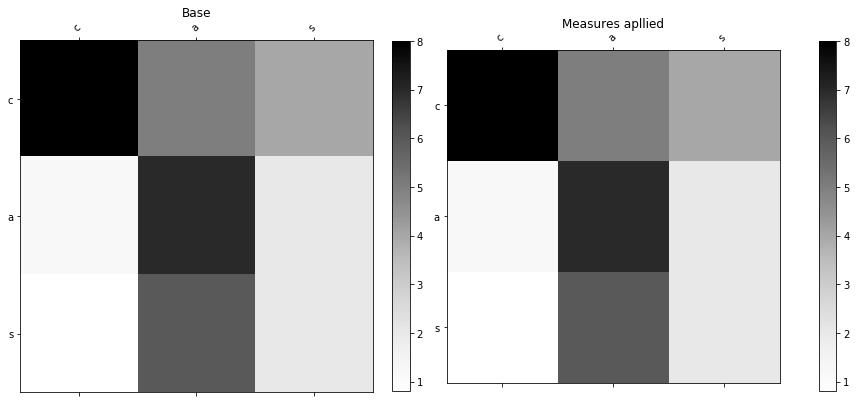

In [10]:
# baseline
ratioBase_household = 1/6
ratioBase_school = 1/6
ratioBase_workplace = 1/6
ratioBase_transport = 1/6
ratioBase_leisure = 1/6
ratioBase_other = 1/6

kBase_household = [
    [8, 5, 4],  
    [1.2, 7, 2], 
    [0.8, 6, 2]]
kBase_school = [
    [8, 5, 4], 
    [1.2, 7, 2], 
    [0.8, 6, 2]] 
kBase_workplace = [
    [8, 5, 4], 
    [1.2, 7, 2], 
    [0.8, 6, 2]] 
kBase_transport = [
    [8, 5, 4], 
    [1.2, 7, 2],
    [0.8, 6, 2]]
kBase_leisure = [
    [8, 5, 4],
    [1.2, 7, 2], 
    [0.8, 6, 2]] 
kBase_other = [
    [8, 5, 4], 
    [1.2, 7, 2], 
    [0.8, 6, 2]] 

kBase = [
    [1, 1, 1], 
    [1, 1, 1], 
    [1, 1, 1]] 

# Measure
ratioMeasure_household = 1/6
ratioMeasure_school = 1/6
ratioMeasure_workplace = 1/6
ratioMeasure_transport = 1/6
ratioMeasure_leisure = 1/6
ratioMeasure_other = 1/6

kMeasure_household = [
    [8, 5, 4],  
    [1.2, 7, 2], 
    [0.8, 6, 2]]
kMeasure_school = [
    [8, 5, 4], 
    [1.2, 7, 2], 
    [0.8, 6, 2]] 
kMeasure_workplace = [
    [8, 5, 4], 
    [1.2, 7, 2], 
    [0.8, 6, 2]] 
kMeasure_transport = [
    [8, 5, 4], 
    [1.2, 7, 2],
    [0.8, 6, 2]]
kMeasure_leisure = [
    [8, 5, 4],
    [1.2, 7, 2], 
    [0.8, 6, 2]] 
kMeasure_other = [
    [8, 5, 4], 
    [1.2, 7, 2], 
    [0.8, 6, 2]] 

kMeasure = [
    [1, 1, 1], 
    [1, 1, 1], 
    [1, 1, 1]] 

for i in range(3):
    for j in range(3):
        kBase[i][j] = kBase_household[i][j] * ratioBase_household + kBase_school[i][j] * ratioBase_school \
                      + kBase_workplace[i][j] * ratioBase_workplace + kBase_transport[i][j] * ratioBase_transport \
                      + kBase_leisure[i][j] * ratioBase_leisure + kBase_other[i][j] * ratioBase_other
        
        kMeasure[i][j] = kMeasure_household[i][j] * ratioMeasure_household \
                         + kMeasure_school[i][j] * ratioMeasure_household \
                         + kMeasure_workplace[i][j] * ratioMeasure_workplace \
                         + kMeasure_transport[i][j] * ratioMeasure_transport \
                         + kMeasure_leisure[i][j] * ratioMeasure_leisure \
                         + kMeasure_other[i][j] * ratioMeasure_other
        

# Variation of [9]
# Basic Configuration
fig, axes = plt.subplots(ncols=2, figsize=(12, 12))
ax1, ax2 = axes

# Heat maps.
im1 = ax1.matshow(kBase, cmap='Greys')
im2 = ax2.matshow(kMeasure, cmap='Greys')

# Formatting for heat map 1.
ax1.set_title("Base")
ax1.set_xticks(range(len(kBase)))
ax1.set_yticks(range(len(kBase)))
ax1.set_xticklabels(['c', 'a', 's'])
ax1.set_yticklabels(['c', 'a', 's'])
ax1.set_ylim(len(kBase)-0.5, -0.5)
plt.setp(ax1.get_xticklabels(), rotation=45, ha='left', rotation_mode='anchor')
plt.colorbar(im1, fraction=0.045, pad=0.05, ax=ax1)

# Formatting for heat map 2.
ax2.set_title("Measures apllied")
ax2.set_xticks(range(len(kMeasure)))
ax2.set_yticks(range(len(kMeasure)))
ax2.set_xticklabels(['c', 'a', 's'])
ax2.set_yticklabels(['c', 'a', 's'])
ax2.set_ylim(len(kMeasure)-0.5, -0.5)
plt.setp(ax2.get_xticklabels(), rotation=45, ha='left', rotation_mode='anchor')
plt.colorbar(im2, fraction=0.045, pad=0.1, ax=ax2)

fig.tight_layout()
plt.show()

####  3.2 Parameters for the model

#### 3.3 Implementing the Colizza model

One important part of the model is the separation of the population in three parts (c, a, s). We have different chances in the different groups for the infection rate and the progression.  
To represent this we created one model per group. The only contact between these three models is the infection phase. Children can not only infect other children, but also adults and seniors.

Using a solver for our function *colizzaModel(...)*, we calculate the development of all three population groups.

In [1]:
def casModel1(status, t, b, k, k_i, e, p_a, p_ps, p_ms, p_ss, u_p, u, p_icu, l_hr, l_hd, l_icur, l_icud):
    # re-create vectors per population group
    S = np.empty(3, dtype=float)
    E = np.empty(3, dtype=float)
    I_p = np.empty(3, dtype=float)
    I_a = np.empty(3, dtype=float)
    I_ps = np.empty(3, dtype=float)
    I_ms = np.empty(3, dtype=float)
    I_ss = np.empty(3, dtype=float)
    H = np.empty(3, dtype=float)
    ICU = np.empty(3, dtype=float)
    R = np.empty(3, dtype=float)
    D = np.empty(3, dtype=float)
    
    for i in range(3):
        S[i] = status[0 + i]
        E[i] = status[3 + i]
        I_p[i] = status[6 + i]
        I_a[i] = status[9 + i]
        I_ps[i] = status[12 + i]
        I_ms[i] = status[15 + i]
        I_ss[i] = status[18 + i]
        H[i] = status[21 + i]
        ICU[i] = status[24 + i]
        R[i] = status[27 + i]
        D[i] =status[ 30 + i]
    
    #prepare return arrays
    dSdT = np.empty(3, dtype=float)
    dEdT = np.empty(3, dtype=float)
    dI_pdT = np.empty(3, dtype=float)
    dI_adT = np.empty(3, dtype=float)
    dI_psdT = np.empty(3, dtype=float)
    dI_msdT = np.empty(3, dtype=float)
    dI_ssdT = np.empty(3, dtype=float)
    dHdT = np.empty(3, dtype=float)
    dICUdT = np.empty(3, dtype=float)
    dRdT = np.empty(3, dtype=float)
    dDdT = np.empty(3, dtype=float)
    
    # Define ODE system
    for i in range(3):     
        dSdT[i] = -b[i] * S[i] * (k[0][i] * (I_p[0] + k_i[0] * I_a[0] + k_i[1] * I_ps[0] + k_i[2] * I_ms[0] + k_i[3] * I_ss[0] ) \
                                  + k[1][i] * (I_p[1] + k_i[0] * I_a[1] + k_i[1] * I_ps[1] + k_i[2] * I_ms[1] + k_i[3] * I_ss[1] ) \
                                  + k[2][i] * (I_p[2] + k_i[0] * I_a[2] + k_i[1] * I_ps[2] + k_i[2] * I_ms[2] + k_i[3] * I_ss[2] ))
        dEdT[i] = - e[i] * E[i] \
                  + b[i] * S[i] * (k[0][i] * (I_p[0] + k_i[0] * I_a[0] + k_i[1] * I_ps[0] + k_i[2] * I_ms[0] + k_i[3] * I_ss[0] ) \
                                 + k[1][i] * (I_p[1] + k_i[0] * I_a[1] + k_i[1] * I_ps[1] + k_i[2] * I_ms[1] + k_i[3] * I_ss[1] ) \
                                 + k[2][i] * (I_p[2] + k_i[0] * I_a[2] + k_i[1] * I_ps[2] + k_i[2] * I_ms[2] + k_i[3] * I_ss[2] )) \
                
        
        dI_pdT[i] = e[i] * E[i] - u_p[i]* (p_a[i]  + (1 - p_a[i]) * (p_ps[i] + p_ms[i] + p_ss[i])) * I_p[i] 
        dI_adT[i] = p_a[i] * u_p[i] * I_p[i] - u[i] * I_a[i]
        dI_psdT[i] = (1 - p_a[i]) * p_ps[i] * u _p[i] * I_p[i] - u[i] * I_ps[i]
        dI_msdT[i] = (1 - p_a[i]) * p_ms[i] * u_p[i] * I_p[i] - u[i] * I_ms[i]
        dI_ssdT[i] = (1 - p_a[i]) * p_ss[i] * u_p[i] * I_p[i] - u[i] * I_ss[i]    
        dHdT[i] = (1 - p_icu[i]) * u[i] * I_ss[i] - (l_hr[i] + l_hd[i]) * H[i]
        dICUdT[i] = p_icu[i] * u[i] * I_ss[i] - (l_icur[i] + l_icud[i]) * ICU[i]   
        dRdT[i] = u[i] * (I_a[i] + I_ps[i] + I_ms[i]) + l_hr[i] * H[i] + l_icur[i] * ICU[i] 
        dDdT[i] = l_hd[i] * H[i] + l_icud[i] * ICU[i]
    
    # return flattened arrays
    return [dSdT[0], dSdT[1], dSdT[2], dEdT[0], dEdT[1], dEdT[2], dI_pdT[0], dI_pdT[1], dI_pdT[2], dI_adT[0], dI_adT[1], dI_adT[2], dI_psdT[0], dI_psdT[1], dI_psdT[2], dI_msdT[0], dI_msdT[1], dI_msdT[2], dI_ssdT[0], dI_ssdT[1], dI_ssdT[2], dHdT[0], dHdT[1], dHdT[2], dICUdT[0], dICUdT[1], dICUdT[2], dRdT[0], dRdT[1], dRdT[2], dDdT[0], dDdT[1], dDdT[2] ]

SyntaxError: invalid syntax (<ipython-input-1-230856e66aab>, line 54)

### 4.1 Results from the Neher model

### 4.2 Results from the Colizza model

### 4.3 Two similar approaches with different focus - comparison of the Coliza and Neher model

### 5. Appendix 
[1] COVID-19 Scenarios: an interactive tool to explore the spread and associated morbidity and mortality of SARS-CoV-2
Nicholas B Noll, Ivan Askamentov, Valentine Druelle, Abrie Badenhorst, Gavin Jefferies, Jan Albert, Richard Neher
medRxiv 2020.05.05.20091363; doi: https://doi.org/10.1101/2020.05.05.20091363
[2] Kermack, W.O., McKendrick, A.G. Contributions to the mathematical theory of epidemics—I. Bltn Mathcal Biology 53, 33–55 (1991). https://doi.org/10.1007/BF02464423
[3] Neher R.A., Dyrdak R., Druelle V., Hodcroft EB., Albert J. Potential impact of seasonal forcing on a SARS-CoV-2 pandemic. Swiss Med Wkly. 150, w20224 (2020). https://doi.org/10.4414/smw.2020.20224
[4] COVID-19 Scenarios https://covid19-scenarios.org/
[5] Jason Phua, Li Weng, Lowell Ling, Moritoki Egi, Chae-Man Lim, Jigeeshu Vasishtha Divatia, Babu Raja Shrestha, Yaseen M Arabi, Jensen Ng, Charles D Gomersall, Masaji Nishimura, Younsuck Koh, Bin Du,
Intensive care management of coronavirus disease 2019 (COVID-19): challenges and recommendations,
The Lancet Respiratory Medicine,
Volume 8, Issue 5,
2020,
Pages 506-517,
ISSN 2213-2600,
https://doi.org/10.1016/S2213-2600(20)30161-2.

[6] Estimates of the severity of COVID-19 disease
Robert Verity, Lucy C Okell, Ilaria Dorigatti, Peter Winskill, Charles Whittaker, Natsuko Imai, Gina Cuomo-Dannenburg, Hayley Thompson, Patrick Walker, Han Fu, Amy Dighe, Jamie Griffin, Anne Cori, Marc Baguelin, Sangeeta Bhatia, Adhiratha Boonyasiri, Zulma M Cucunuba, Rich Fitzjohn, Katy A M Gaythorpe, Will Green, Arran Hamlet, Wes Hinsley, Daniel Laydon, Gemma Nedjati-Gilani, Steven Riley, Sabine van-Elsand, Erik Volz, Haowei Wang, Yuanrong Wang, Xiayoue Xi, Christl Donnelly, Azra Ghani, Neil Ferguson
medRxiv 2020.03.09.20033357; doi: https://doi.org/10.1101/2020.03.09.20033357

[5] INSERM, Sorbonne Université, Pierre Louis Institute of Epidemiology and Public Health, Paris, France  
[6] Di Domenico et al,Expected impact of lockdown in Ile-de-France and possible exit strategies, Report #9, medRxiv.org  
[7] Van Kerckhove, K., Hens, N., Edmunds, W. J. & Eames, K. T. D. The Impact of Illness on Social Networks: Implications for Transmission and Control of Influenza. Am. J. Epidemiol. 178, 1655– 1662 (2013)  
[8] APHP. https://www.aphp.fr/  
[9] https://stackoverflow.com/questions/55663030/plotting-two-heat-maps-side-by-side-in-matplotlib
